In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

from utils.data_utils import load_movement_df # import data loading stuff
from utils.plot_utils import *                # import plotting stuff


path_to_data = os.path.join('..', '..', 'data')

# load scenarios for synthetic inferences
scenarios_df = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))


In [2]:
def capitalize_string_df(df_cap, col_cap):
    df_cap[col_cap] = df_cap[col_cap].map(lambda x: ' '.join([w.lower().capitalize() for w in str(x).split(' ')] ) )
    return df_cap

In [3]:
amr_places_df = pd.read_csv(os.path.join(feb_hosp_records_path, "micro_long2021-08-25_place.csv"), parse_dates=["date_long", "date"]).drop(columns=["Unnamed: 0"])
amr_places_df["organism_category"] = amr_places_df["organism_category"].fillna("None")
amr_places_df["abnormal_result"]   = amr_places_df["abnormal_result"].fillna("N")
amr_places_df["organism_group"]    = amr_places_df["organism_group"].fillna("None")
amr_places_df["organism_name"]     = amr_places_df["organism_name"].fillna("None")

amr_places_df                    = capitalize_string_df(amr_places_df, "procedure_description" )
amr_places_df['place'].replace({"1": 'Columbia', "2":'Allen', "3":'Chony'}, inplace=True)
amr_places_df                    = capitalize_string_df(amr_places_df, "site" )
amr_places_df                    = capitalize_string_df(amr_places_df, "ward" )
amr_places_df                    = capitalize_string_df(amr_places_df, "room" )
amr_places_df["num_tests"]       = 1


In [4]:
test_ward_df = amr_places_df.groupby(["date",  "place", "site", "ward", "room"]).sum()[["num_tests"]]
test_per_place_ward_df         = test_ward_df.reset_index().groupby(["place", "site", "ward"]).sum()[["num_tests"]].reset_index()
test_per_place_ward_df["ward"] = test_per_place_ward_df.apply(lambda x: x.site+"-"+x.ward, axis=1)
test_per_place_ward_df         = test_per_place_ward_df[test_per_place_ward_df["place"]!="True"]


test_per_place_site_df = test_ward_df.reset_index().groupby(["place", "site"]).sum()[["num_tests"]].reset_index()
test_per_place_site_df = test_per_place_site_df[test_per_place_site_df["place"]!="True"]


In [5]:
import pylab

cm         = pylab.get_cmap('gist_ncar')
NUM_COLORS = test_per_place_site_df["place"].unique().shape[0]
cm(1.*0/NUM_COLORS)
place2color = {place: cm(1.*place_idx/NUM_COLORS) for place_idx, place in enumerate(test_per_place_site_df.place.unique())}

test_per_place_site_df["color"] = test_per_place_site_df["place"].map(place2color)
test_per_place_ward_df["color"] = test_per_place_ward_df["place"].map(place2color)

test_per_place_site_df["log_num_tests"] = np.log(test_per_place_site_df["num_tests"])
test_per_place_ward_df["log_num_tests"] = np.log(test_per_place_ward_df["num_tests"])


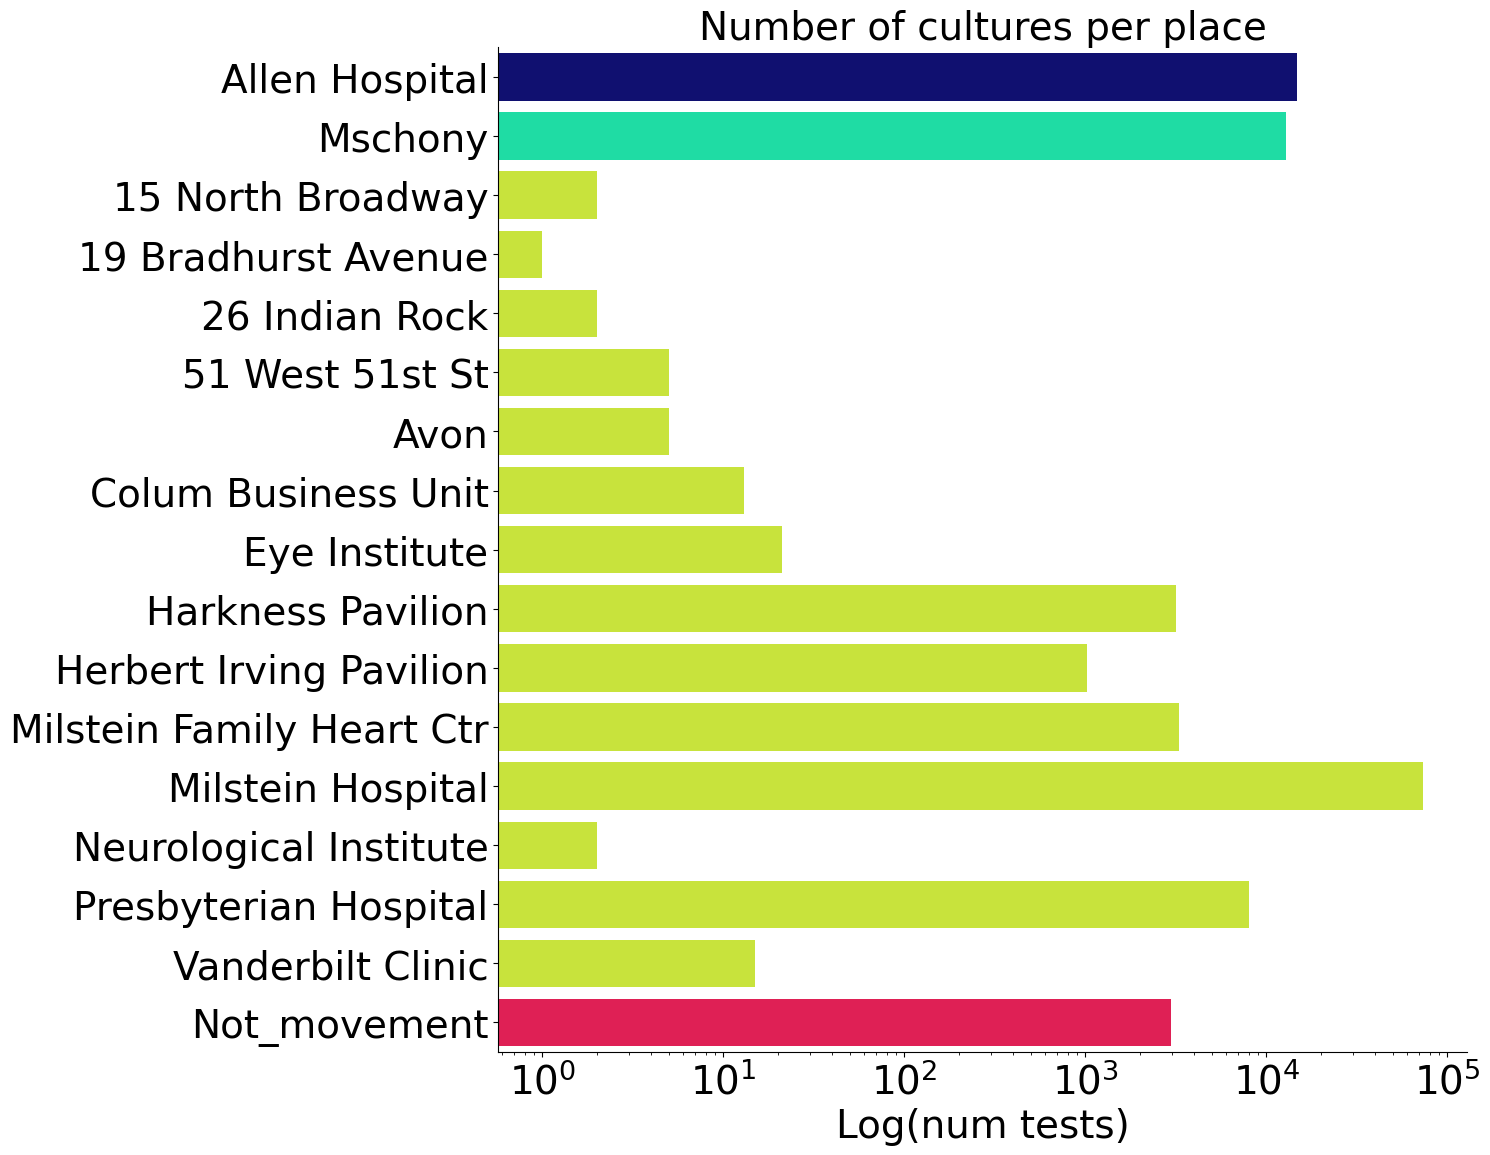

In [6]:
import seaborn as sns


fig, ax = plt.subplots(1, 1, figsize=(15.5, 12.2), sharey=True)

sns.barplot(ax=ax, x="num_tests", y="site", data=test_per_place_site_df,
            label="Total", palette=test_per_place_site_df["color"].values)


ax.set_title("Number of cultures per place")
ax.tick_params(which='both', axis='both')
ax.set_xlabel("Number of tests")
ax.set_ylabel(None)
ax.set_xlabel("Log(num tests)")
ax.set_xscale("log")

sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

plt.tight_layout()

path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "CulturePerPlace.png")
fig.savefig(path_to_save_fig, dpi=300, transparent=True)



In [7]:
test_per_place_ward_df.place.unique()

array(['Allen', 'Chony', 'Columbia', 'not_movement'], dtype=object)

In [8]:
test_per_place_ward_df["ward_no_place"] = test_per_place_ward_df["ward"].apply(lambda x: x.split("-")[-1])
test_per_place_ward_df["ward_to_plot"]  = test_per_place_ward_df.reset_index().apply(lambda x: "ward"+f" {str(x['index']).zfill(3)}", axis=1)
test_per_place_ward_df

,place,site,ward,num_tests,color,log_num_tests,ward_no_place,ward_to_plot
0,Allen,Allen Hospital,Allen Hospital-Aln 1 River West,213,"(0.0, 0.0, 0.502, 1.0)",5.361292,Aln 1 River West,ward 000
1,Allen,Allen Hospital,Allen Hospital-Aln 2 Col Proc Card Med,5,"(0.0, 0.0, 0.502, 1.0)",1.609438,Aln 2 Col Proc Card Med,ward 001
2,Allen,Allen Hospital,Allen Hospital-Aln 2 Field East,3,"(0.0, 0.0, 0.502, 1.0)",1.098612,Aln 2 Field East,ward 002
3,Allen,Allen Hospital,Allen Hospital-Aln 2 Field West,27,"(0.0, 0.0, 0.502, 1.0)",3.295837,Aln 2 Field West,ward 003
4,Allen,Allen Hospital,Allen Hospital-Aln 2 River West,16,"(0.0, 0.0, 0.502, 1.0)",2.772589,Aln 2 River West,ward 004
...,...,...,...,...,...,...,...,...
154,Columbia,Presbyterian Hospital,Presbyterian Hospital-Pby Radiation Oncology,211,"(0.8573751723275831, 1.0, 0.12482388288648784,...",5.351858,Pby Radiation Oncology,ward 154
155,Columbia,Presbyterian Hospital,Presbyterian Hospital-Vc 3 Pft Main Lab,72,"(0.8573751723275831, 1.0, 0.12482388288648784,...",4.276666,Vc 3 Pft Main Lab,ward 155
156,Columbia,Vanderbilt Clinic,Vanderbilt Clinic-Vc 15 Col Dermapathology,2,"(0.8573751723275831, 1.0, 0.12482388288648784,...",0.693147,Vc 15 Col Dermapathology,ward 156
157,Columbia,Vanderbilt Clinic,Vanderbilt Clinic-Vc Col Path Lab Outreach,13,"(0.8573751723275831, 1.0, 0.12482388288648784,...",2.564949,Vc Col Path Lab Outreach,ward 157


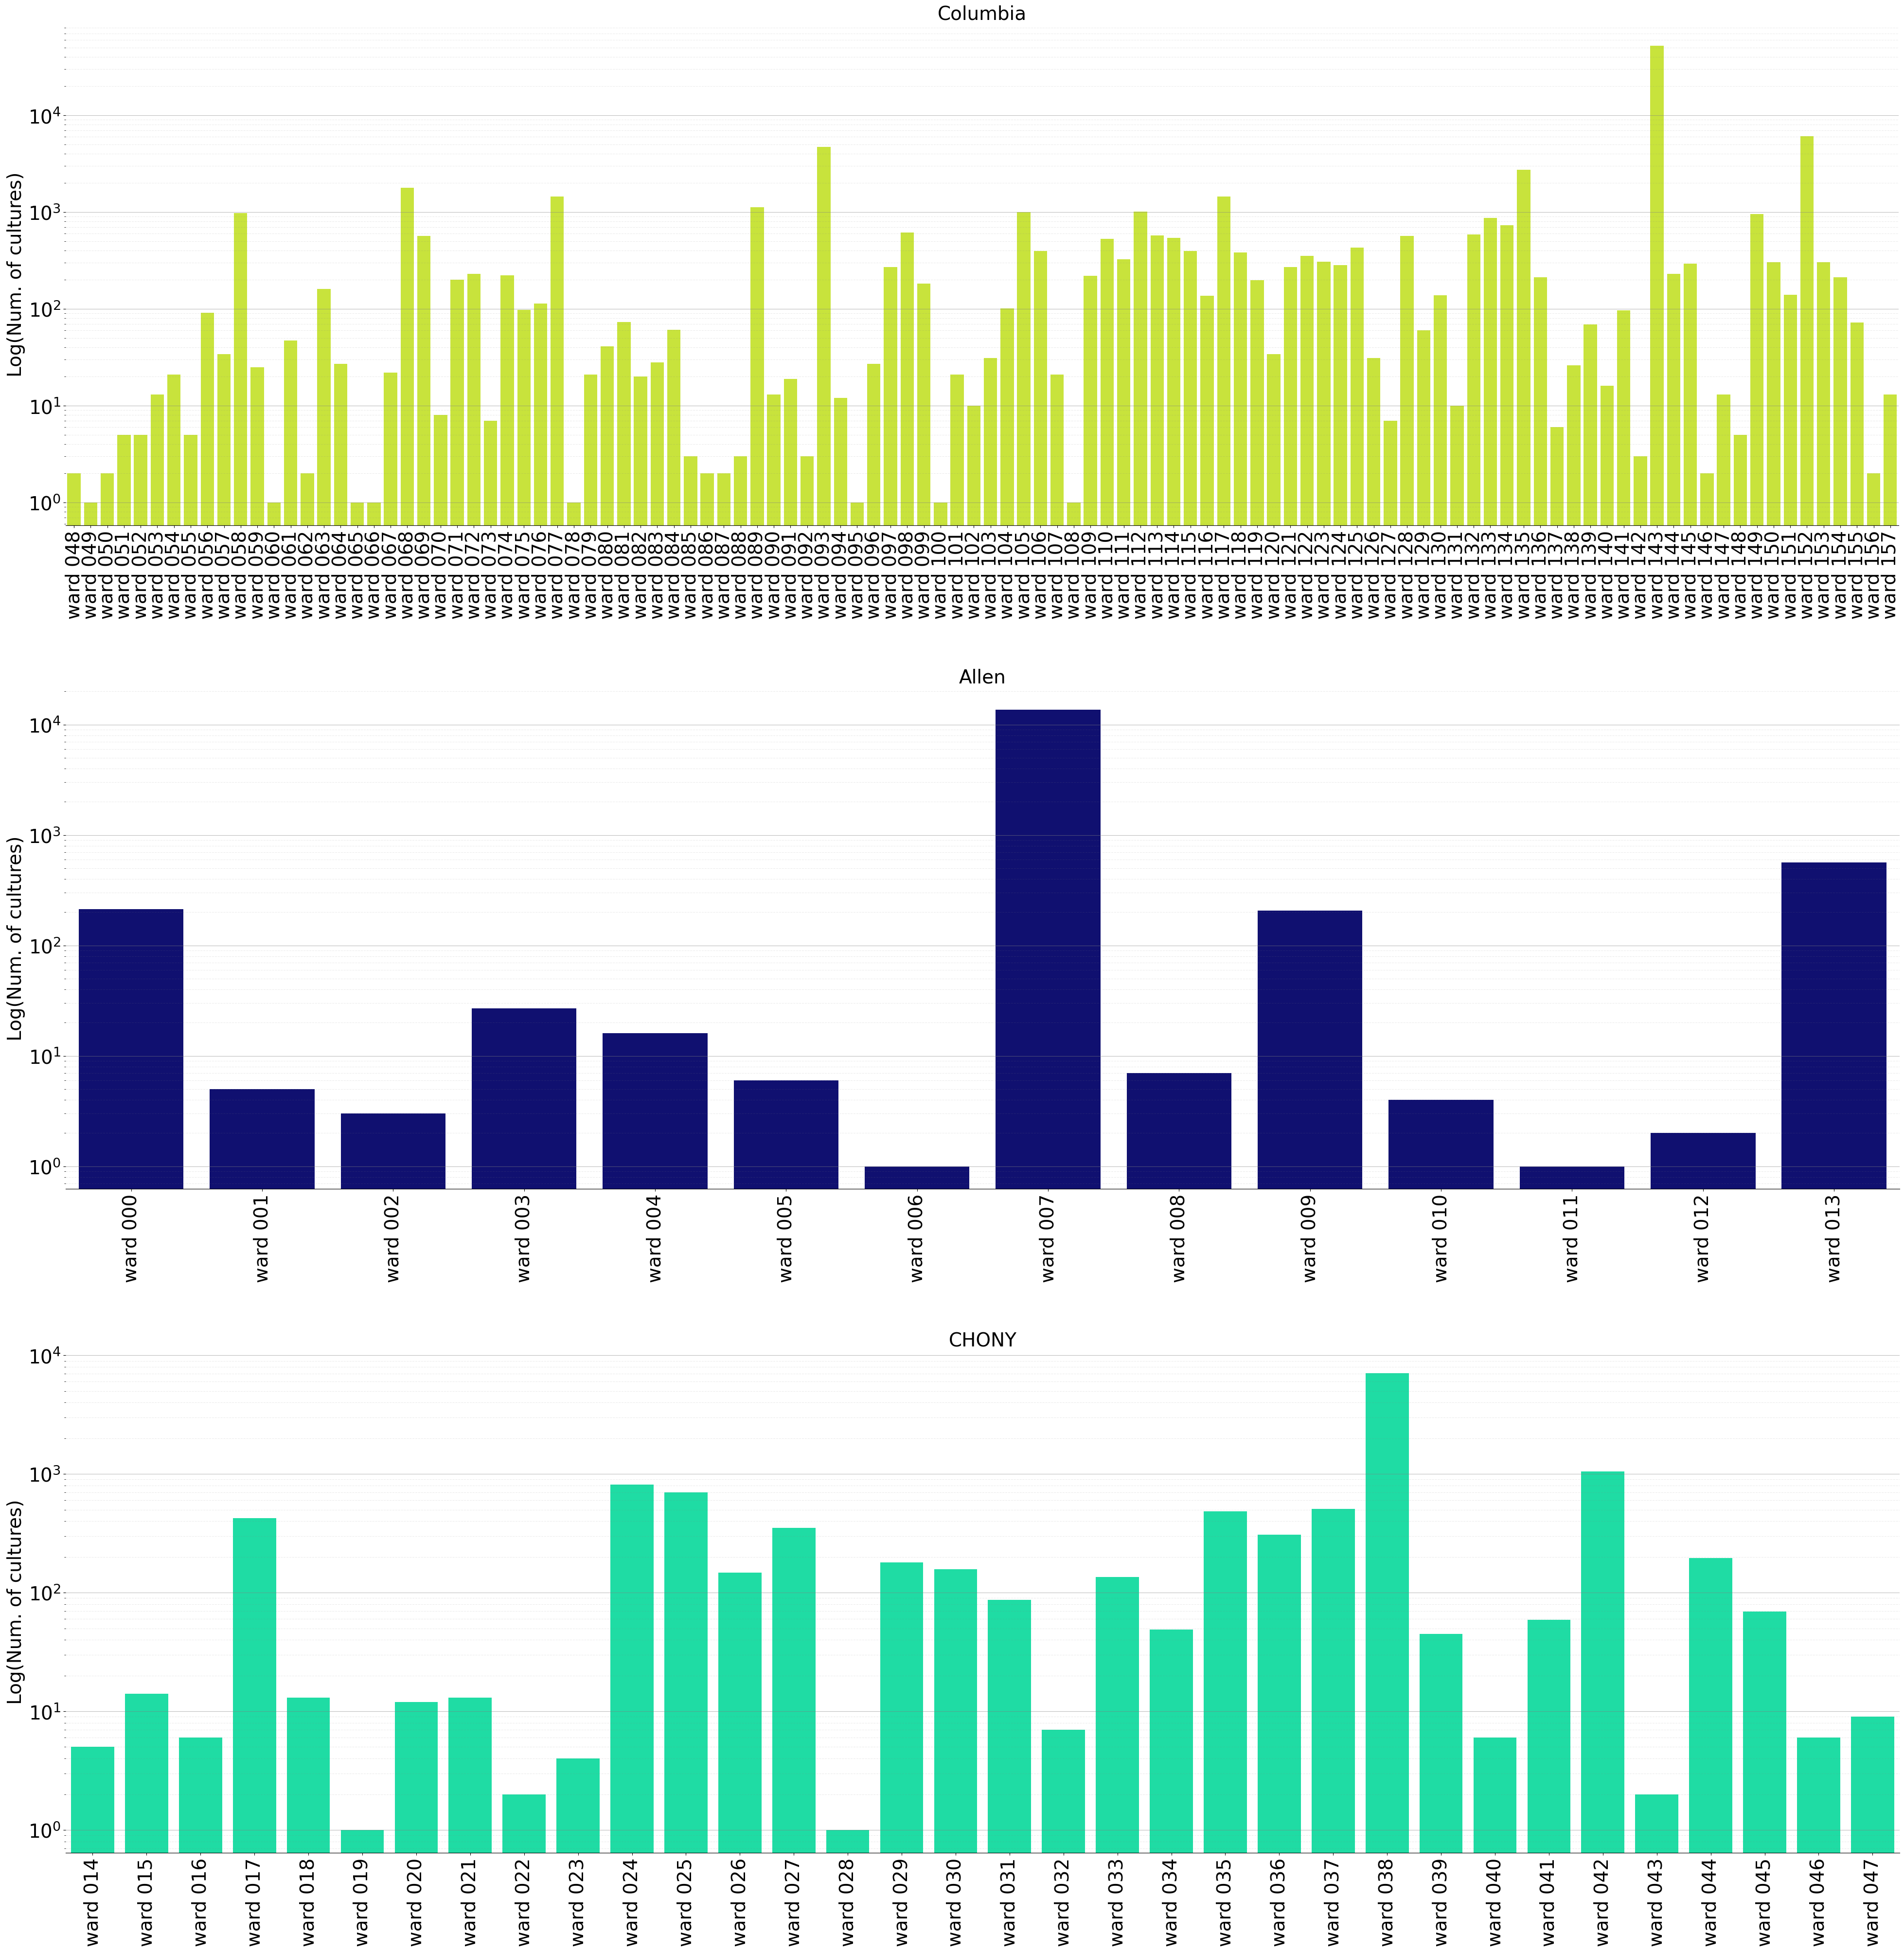

In [10]:
# First figure: Violin plots MLEs
fig     = plt.figure(constrained_layout=True, figsize=(39, 40))
subfigs = fig.subfigures(3, 1, hspace=0.07, wspace=0.1,  height_ratios=[1/3, 1/3, 1/3])

ax1     = subfigs[0].subplots(1, 1)
sns.barplot(ax=ax1, y="num_tests", x="ward_to_plot", data=test_per_place_ward_df[test_per_place_ward_df.place=="Columbia"],
            label="Total", palette=test_per_place_ward_df[test_per_place_ward_df.place=="Columbia"]["color"].values, ci=None)

ax1.set_title("Columbia")
ax1.tick_params(which='both', axis='both')
ax1.set_ylabel("Log(Num. of cultures)")
ax1.set_yscale('log')
ax1.set_xlabel(None)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

sns.despine(ax=ax1, top=True, right=True, left=True, bottom=False)
ax1.grid(axis='y', linestyle='-', which='major', color='grey', alpha=.5)
ax1.grid(axis='y', linestyle='--', which='minor', color='grey', alpha=.15)

########################

ax1    = subfigs[1].subplots(1, 1)
sns.barplot(ax=ax1, y="num_tests", x="ward_to_plot", data=test_per_place_ward_df[test_per_place_ward_df.place=="Allen"],
            label="Total", palette=test_per_place_ward_df[test_per_place_ward_df.place=="Allen"]["color"].values, ci=None)

ax1.set_title("Allen")
ax1.tick_params(which='both', axis='both')
ax1.set_ylabel("Log(Num. of cultures)")
ax1.set_yscale('log')
ax1.set_xlabel(None)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

sns.despine(ax=ax1, top=True, right=True, left=True, bottom=False)
ax1.grid(axis='y', linestyle='-', which='major', color='grey', alpha=.5)
ax1.grid(axis='y', linestyle='--', which='minor', color='grey', alpha=.15)

########################

ax1    = subfigs[2].subplots(1, 1)
sns.barplot(ax=ax1, y="num_tests", x="ward_to_plot", data=test_per_place_ward_df[test_per_place_ward_df.place=="Chony"],
            label="Total", palette=test_per_place_ward_df[test_per_place_ward_df.place=="Chony"]["color"].values)

ax1.set_title("CHONY")
ax1.tick_params(which='both', axis='both')
ax1.set_ylabel("Log(Num. of cultures)")
ax1.set_yscale('log')
ax1.set_xlabel(None)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

sns.despine(ax=ax1, top=True, right=True, left=True, bottom=False)
ax1.grid(axis='y', linestyle='-', which='major', color='grey', alpha=.5)
ax1.grid(axis='y', linestyle='--', which='minor', color='grey', alpha=.15)

path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "CulturesPerInstitution.png")
fig.savefig(path_to_save_fig, dpi=300, transparent=True)